## Exploring Rossmann Drug Store Sales Data | Starter Code

In [43]:
import pandas as pd
import seaborn as sns

data = pd.read_csv('../../dataset/rossmann.csv', skipinitialspace=True, low_memory=False)

Because we are most interested in the `Date` column that contains the date of sales for each store, we will make sure to process that as a `DateTime` type, and make that the index of our dataframe.

In [44]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

data['Year'] = data.index.year
data['Month'] = data.index.month

In [55]:
store1_data = data[data.Store == 1]

### Data Exploration and MINEing

To compare sales on holidays, we can compare the sales using box-plots, which allows us to compare the distribution of sales on holidays against all other days.  On state holidays, the store is closed (and as a nice sanity check there are 0 sales), and on school holidays the sales are relatively similar.

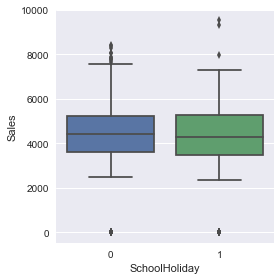

In [46]:
import seaborn as sb
%matplotlib inline

sb.factorplot(
    x='SchoolHoliday',
    y='Sales',
    data=store1_data, 
    kind='box'
)

> Check: See if there is a difference affecting sales on promotion days.

In [47]:
# TODO

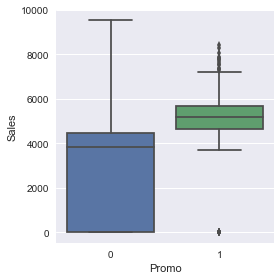

In [48]:
sb.factorplot(
    x='Promo',
    y='Sales',
    data=store1_data, 
    kind='box'
)

Lastly, we want to identify larger-scale trends in our data. How did sales change from 2014 to 2015? Were there any particularly interesting outliers in terms of sales or customer visits?

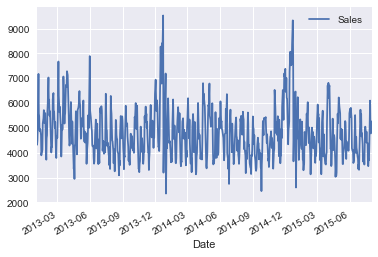

In [49]:
# Filter to days store 1 was open
store1_open_data = store1_data[store1_data.Open==1]
store1_open_data[['Sales']].plot()

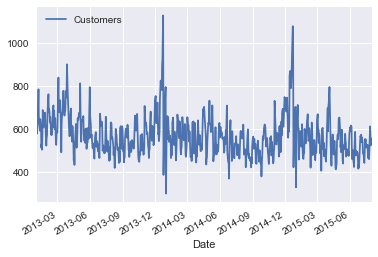

In [50]:
store1_open_data[['Customers']].plot()

In pandas, we can compute rolling average using the `pd.rolling_mean` or `pd.rolling_median` functions.

### Data REFINING Using Time Series Statistics

### Autocorrelation

To measure how much the sales are correlated with each other, we want to compute the _autocorrelation_ of the 'Sales' column. In pandas, we do this we with the `autocorr` function:

`autocorr` takes one argument, the `lag` which is how many prio data points should be used to compute the correlation. If we set the `lag` to 1, we compute the correlation between every point and the point directly preceding it. Setting `lag` to 10 computes the correlation between every point and the point 10 days earlier.

In [51]:
data['Sales'].resample('D').mean().autocorr(lag=1)

-0.025858276006383584

### Rolling Averages

If we want to investigate trends over time in sales, as always, we will start by computing simple aggregates.  What were the mean and median sales for each month and year?

In Pandas, this is performed using the `resample` command, which is very similar to the `groupby` command. It allows us to group over different time intervals.

We can use `data.resample` and provide as arguments:
    - The level on which to roll-up to, 'D' for day, 'W' for week, 'M' for month, 'A' for year
    - What aggregation to perform: 'mean', 'median', 'sum', etc.

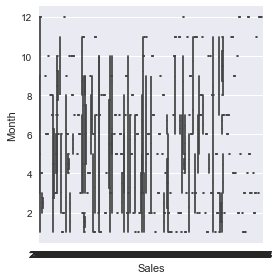

In [52]:
sb.factorplot(
    x='Sales',
    y='Month',
    data=store1_data, 
    kind='box'
)

In [11]:
data[['Sales']].resample('M').apply(['median', 'mean']).head()

Sales             
            median         mean
Date                           
2013-01-31  5194.0  5211.555578
2013-02-28  5421.5  5494.371397
2013-03-31  5844.0  5820.349168
2013-04-30  5464.0  5483.749836
2013-05-31  5585.0  5364.127383

While identifying the monthly averages is useful, we often want to compare the sales data of a date to a smaller window. To understand holidays sales, we don't want to compare late December with the entire month, but perhaps with a few days surrounding it. We can do this using rolling averages.

In pandas, we can compute rolling average using the `pd.rolling_mean` or `pd.rolling_median` functions.

In [1]:
data[['Sales']].resample('D').mean().head()

NameError: name 'data' is not defined

In [17]:
data[['Sales']].resample('W').mean().rolling(window=3, center=True).mean().head()

Sales
Date                   
2013-01-06          NaN
2013-01-13  4874.728530
2013-01-20  5538.891992
2013-01-27  5077.256588
2013-02-03  5701.835618

`rolling_mean` (as well as `rolling_median`) takes these important parameters:
    - the first is the series to aggregate
    - `window` is the number of days to include in the average
    - `center` is whether the window should be centered on the date or use data prior to that date
    - `freq` is on what level to roll-up the averages to (as used in `resample`). Either `D` for day, `M` for month or `A` for year, etc.

Instead of plotting the full timeseries, we can plot the rolling mean instead, which smooths random changes in sales as well as removing outliers, helping us identify larger trends.

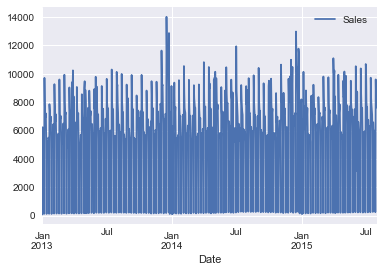

In [20]:
data[['Sales']].resample('D').mean().plot()

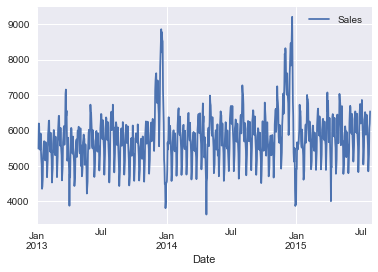

In [30]:
data[['Sales']].resample('D').mean().rolling(window=10, center=True).mean().plot()

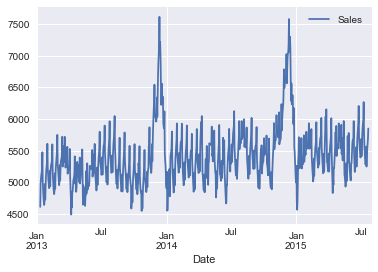

In [31]:
data[['Sales']].resample('D').median().rolling(window=20, center=True).mean().plot()

### Pandas Window functions
Pandas `rolling_mean` and `rolling_median` are only two examples of Pandas window function capabilities. Window functions are operate on a set of N consecutive rows (a window) and produce an output.

In addition to `rolling_mean` and `rolling_median`, there are `rolling_sum`, `rolling_min`, `rolling_max`... and many more.

Another common one is `diff`, which takes the difference over time. `pd.diff` takes one arugment, `periods`, which is how many rows prior to use for the difference.


In [33]:
store1_datastore1_data.head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31      1          5   5263        555     1      1            0   
2015-07-30      1          4   5020        546     1      1            0   
2015-07-29      1          3   4782        523     1      1            0   
2015-07-28      1          2   5011        560     1      1            0   
2015-07-27      1          1   6102        612     1      1            0   

            SchoolHoliday  Year  Month  
Date                                    
2015-07-31              1  2015      7  
2015-07-30              1  2015      7  
2015-07-29              1  2015      7  
2015-07-28              1  2015      7  
2015-07-27              1  2015      7

In [34]:
data['Sales'].diff(periods=1).head()

Date
2015-07-31       NaN
2015-07-31     801.0
2015-07-31    2250.0
2015-07-31    5681.0
2015-07-31   -9173.0
Name: Sales, dtype: float64

### Pandas expanding functions

In addition to the set of `rolling_*` functions, Pandas also provides a similar collection of `expanding_*` functions, which, instead of using a window of N values, use all values up until that time.

In [35]:
# computes the average sales, from the first date _until_ the date specified.
data[['Sales']].resample('D').mean().expanding().mean().head()


Sales
Date                   
2013-01-01    87.284560
2013-01-02  3160.157527
2013-01-03  4004.475720
2013-01-04  4491.911499
2013-01-05  4661.079513

## Exercises

> Plot the distribution of sales by month and compare the effect of promotions

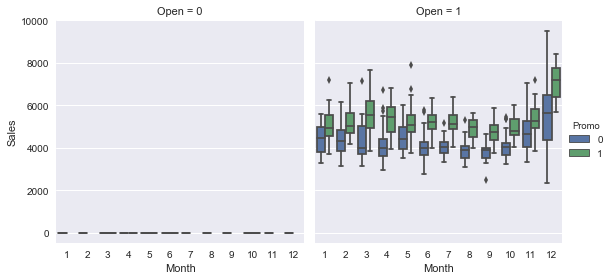

In [56]:
sns.factorplot(
    col='Open',
    hue = 'Promo',
    x= 'Month',
    y = 'Sales',
    data= store1_data,
    kind='box'
)

> Are sales more correlated with the prior date, a similar date last year, or a similar date last month?

In [59]:
average_daily_sales = data[['Sales', 'Open']].resample('D').mean()
average_daily_sales['Sales'].autocorr(lag=1)

-0.025858276006383584

In [60]:
average_daily_sales['Sales'].autocorr(lag=30)

-0.12984245822530621

In [61]:
average_daily_sales['Sales'].autocorr(lag=365)

0.020238529448344554

> Plot the 15 day rolling mean of customers in the stores

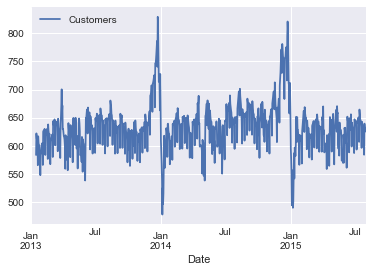

In [65]:
data[['Customers']].resample('D').mean().rolling(window=15).mean().plot()

> Identify the date with largest drop in sales from the same date in the previous month

In [73]:
store1_data[['Sales', 'Open']].resample('D').mean().diff(31).sort_values(by='Sales').min()

Sales   -7785.0
Open       -1.0
dtype: float64

> Compute the total sales up until Dec. 2014

In [84]:
store1_data['Sales'].resample('D').sum().expanding().sum()['2014-12'].head()

Date
2014-12-01    2770902.0
2014-12-02    2777369.0
2014-12-03    2783823.0
2014-12-04    2790839.0
2014-12-05    2797046.0
Freq: D, Name: Sales, dtype: float64

> When were the largest differences between 15-day moving/rolling averages?
> HINT: Using `rolling_mean` and `diff`

In [101]:
data[['Sales']].resample('D').mean().rolling(window=15).mean().diff(1).sort_values(by='Sales')

Sales
Date                  
2014-01-01 -773.446039
2015-01-01 -668.394774
2013-12-31 -663.000538
2014-01-05 -596.739073
2014-05-01 -585.158326
2015-01-04 -555.511718
2015-05-14 -551.776143
2013-04-14 -549.940867
2015-04-19 -545.842511
2015-05-17 -508.777519
2014-12-14 -505.303173
2013-12-15 -502.268819
2014-05-04 -490.314081
2015-05-01 -486.244783
2014-12-31 -479.534332
2014-04-18 -477.901166
2015-04-03 -468.245620
2014-12-28 -467.818538
2013-12-29 -461.087713
2014-10-19 -443.571622
2014-12-21 -443.504670
2013-12-25 -437.408550
2015-06-14 -435.111271
2014-10-03 -434.188164
2013-11-17 -431.443587
2015-03-15 -429.132436
2013-12-26 -429.059073
2015-02-15 -426.746786
2014-12-26 -424.364064
2013-12-22 -416.571719
...                ...
2014-06-02  683.282631
2014-04-14  686.164066
2015-06-01  686.872048
2014-02-03  692.493991
2014-11-03  695.101747
2015-06-29  696.390972
2014-03-31  708.508700
2014-12-01  718.254403
2015-03-30  725.079103
2013-12-02  763.995516
2014-12-22  770.850053
2014-06-30  781.484544
2013-12-23  846.632646
2014-12-15  847.866310
2013-12-16  920.987444
2013-01-01         NaN
2013-01-02         NaN
2013-01-03         NaN
2013-01-04         NaN
2013-01-05         NaN
2013-01-06         NaN
2013-01-07         NaN
2013-01-08         NaN
2013-01-09         NaN
2013-01-10         NaN
2013-01-11         NaN
2013-01-12         NaN
2013-01-13         NaN
2013-01-14         NaN
2013-01-15         NaN

[942 rows x 1 columns]